# DST Clustering
An attempt to use HAPI-NN to determine cluster different DST events.

## Setup
Import HAPI and other packages

In [1]:
from hapiclient import hapi
from datetime import datetime
from hapi_nn import HAPINNTrainer, HAPINNTester, config
import hapi_nn
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
warnings.simplefilter('always')

### HAPI Setup
Set HAPI related parameters

In [3]:
config.MODEL_ENGINE = 'TENSORFLOW'

server = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset = 'OMNI2_H0_MRG1HR'
#Provisional Dst (2015/001-2020/366)
start = '2016-01-01T00:00:00Z'
stop = '2020-01-01T00:00:00Z'

start2 = '2015-01-01T00:00:00Z'
stop2 = '2016-01-01T00:00:00Z'

parameters = 'DST1800'
options = {'logging': True, 'usecache': True, 'cachedir': './hapicache'}

## Create HAPI-NN Trainer and Tester
Begin testing HAPI-NN

### Parameters

In [4]:
# Note the period size has effect on the duration of events that can be clustered
in_steps = 24 * 4  # 4 days
out_steps = in_steps

### Create Trainer and Tester as well as load data with HAPI

Create Trainer

In [5]:
splits = (.7, .2, .1)  # Train, Validation, Test
    
trainer = HAPINNTrainer(
    splits, in_steps, out_steps,
    preprocess_func=None,
    lag=False
)

Load data for Training

Model input will come from scalar and vector in HAPI dataset. The output comes from the first element in the column.
The input is lagged behind the output, so we are forecasting the outputs based on the inputs.

In [6]:
data, meta = hapi(server, dataset, parameters, start, stop, **options)
trainer.set_hapidatas([data], xyparameters=[['DST1800'], ['DST1800']])

hapi(): Running hapi.py version 0.2.4
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI2_H0_MRG1HR_DST1800_20160101T000000_20200101T000000.pkl
hapi(): Reading OMNI2_H0_MRG1HR_DST1800_20160101T000000_20200101T000000.npy 


3600.0

In [7]:
len(data)

35064

Prepare the downloaded data for training

In [8]:
trainer.prepare_data()

/home/jovyan/HAPI_NN/hapi_nn/training.py:349: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)
/home/jovyan/HAPI_NN/hapi_nn/training.py:359: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(remerge_data)


(0.7034152532594901, 0.20099226952809507, 0.0955924772124149)

Test saving and loading

In [9]:
trainer.save_prepared_data('data')

In [10]:
trainer.load_prepared_data('./data')

Create Tester

In [11]:
def custom_handle_2_outputs(x):
    # Tester is used for full and encoder model
    # Tester cannot handle seperate output heads, handling here
    if isinstance(x, np.ndarray):
        # handle numpy case or normal model case
        return x
    else:
        # handle encoder case with two outputs, take first
        return x[0]

tester = HAPINNTester(
    in_steps, out_steps, preprocess_func=None,
    preprocess_y_func=custom_handle_2_outputs
)

Load data for testing

In [12]:
data, meta = hapi(server, dataset, parameters, start2, stop2, **options)
tester.set_hapidatas([data], xyparameters=[['DST1800'], ['DST1800']])

hapi(): Running hapi.py version 0.2.4
hapi(): file directory = ./hapicache/cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI2_H0_MRG1HR_DST1800_20150101T000000_20160101T000000.pkl
hapi(): Reading OMNI2_H0_MRG1HR_DST1800_20150101T000000_20160101T000000.npy 


3600.0

In [13]:
len(data)

8760

Prepare data for testing

In [14]:
tester.prepare_data()

### Create Model

Create TensorFlow Model

In [15]:
# Higher compression ratio the more difficult reconstructing the input will be
compression_ratio = 6
compression = in_steps // compression_ratio

In [16]:
class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, rloss_coef=1000, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.rloss_coef = rloss_coef
        self.decoder.compiled_loss.build(
            tf.zeros(self.decoder.output_shape[1:])
        )
        self.rloss = self.decoder.compiled_loss._losses[0]
        
    def train_step(self, x):
        if isinstance(x, (tuple, list)):
            x = x[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            eps = tf.random.normal(shape=tf.shape(z_mean))
            z = eps * tf.exp(z_log_var * .5) + z_mean
            reconstruction_loss = self.rloss.fn(
                x, self.decoder(z, training=True)
            )
            reconstruction_loss = tf.reduce_mean(
                reconstruction_loss
            )
            divergence_loss = .5 * tf.reduce_mean(
                tf.exp(z_log_var) + z_mean**2 - 1. - z_log_var
            )
            loss = reconstruction_loss * self.rloss_coef + divergence_loss
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            'loss': loss,
            'reconstruction_loss': reconstruction_loss,
            'divergence_loss': divergence_loss
        }
    
    def call(self, inputs, training=False):
        z_mean, z_log_var = self.encoder(inputs, training=training)
        eps = tf.random.normal(shape=tf.shape(z_mean))
        z = eps * tf.exp(z_log_var * .5) + z_mean
        y = self.decoder(z, training=training)
        return y

In [17]:
x0 = keras.layers.Input(shape=(in_steps, 1))
x = keras.layers.Conv1D(compression, 5, strides=2, padding='same', activation='swish')(x0)
x = keras.layers.Conv1D(compression * 2, 5, strides=2, padding='same', activation='swish')(x)
x = keras.layers.Conv1D(compression * 4, 5, strides=2, padding='same', activation='swish')(x)
x = keras.layers.Conv1D(compression * 8, 5, strides=2, padding='same', activation='swish')(x)
x = keras.layers.Conv1D(compression * 8, 3, strides=2, padding='same', activation='swish')(x)
x = keras.layers.Conv1D(compression * 16, 3, strides=3)(x)

x = keras.layers.Flatten()(x)
z_mean = keras.layers.Dense(compression)(x)
z_log_var = keras.layers.Dense(compression)(x)
z_log_var = keras.layers.Lambda(
    lambda x: tf.clip_by_value(x, -50, 50)  # helps to avoid NaN
)(z_log_var)
encoder_model = keras.Model(inputs=x0, outputs=[z_mean, z_log_var])
encoder_model.compile(
    optimizer='adam', loss='mse', metrics=['mae']
)
encoder_model.summary()

x0 = keras.layers.Input(shape=(compression,))
x = keras.layers.Dense(compression * 8)(x0)
x = keras.layers.Reshape((1, compression * 8))(x)
x = keras.layers.Conv1DTranspose(compression * 16, 3, strides=3)(x)
x = keras.layers.Conv1DTranspose(compression * 8, 3, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression * 8, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression * 4, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression * 2, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(compression, 5, strides=2, padding='same')(x)
x = keras.layers.Conv1DTranspose(1, 1, strides=1, padding='same')(x)
decoder_model = keras.Model(inputs=x0, outputs=x)
decoder_model.compile(optimizer=keras.optimizers.Adam(.001), loss='mse', metrics=['mae'])
decoder_model.summary()

model = VAEModel(encoder_model, decoder_model, rloss_coef=2)
model.compile(optimizer=decoder_model.optimizer,
              loss=decoder_model.loss,
              metrics=decoder_model.compiled_metrics._metrics)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 16)       96          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 24, 32)       2592        ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 12, 64)       10304       ['conv1d_1[0][0]']               
                                                                                              

2022-07-21 21:50:12.412454: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_2 (Dense)             (None, 128)               2176      
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 3, 256)           98560     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 6, 128)           98432     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 12, 128)          8204

### Train the model

In [18]:
epochs = 20
batch_size = 32

trainer.train(model, epochs, batch_size=batch_size)

Epoch 1/20
763/763 [==============================] - 10s 12ms/step - loss: 81.8882 - reconstruction_loss: 39.3984 - divergence_loss: 3.0915 - val_loss: 28.1063 - val_mae: 3.8726
Epoch 2/20
763/763 [==============================] - 8s 11ms/step - loss: 25.5194 - reconstruction_loss: 18.5674 - divergence_loss: 2.9483 - val_loss: 17.1543 - val_mae: 2.9605
Epoch 3/20
763/763 [==============================] - 8s 11ms/step - loss: 36.7930 - reconstruction_loss: 16.9231 - divergence_loss: 2.8526 - val_loss: 17.9369 - val_mae: 3.0562
Epoch 4/20
763/763 [==============================] - 8s 11ms/step - loss: 26.1985 - reconstruction_loss: 17.6169 - divergence_loss: 2.9038 - val_loss: 12.0933 - val_mae: 2.4945
Epoch 5/20
763/763 [==============================] - 8s 11ms/step - loss: 23.6610 - reconstruction_loss: 12.2817 - divergence_loss: 2.9449 - val_loss: 12.4506 - val_mae: 2.5311
Epoch 6/20
763/763 [==============================] - 8s 11ms/step - loss: 30.6230 - reconstruction_loss: 13.

{'train': [10.75247859954834, 2.362426519393921],
 'val': [10.662980079650879, 2.3579931259155273],
 'test': [9.677688598632812, 2.342444658279419]}

## Utilize Model

Predict over the downloaded testing data using the default stride (out_steps)

In [19]:
predictions = tester.test(model)
len(predictions)

91

Display one window of the test data overlayed with the prediction values

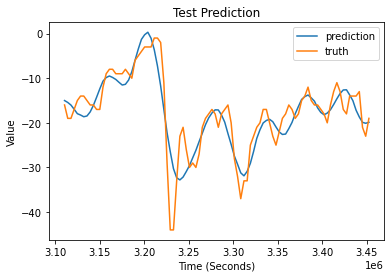

In [20]:
tester.plot(predictions, 9, 'DST1800')

Display all of the test data overlayed with the prediction values

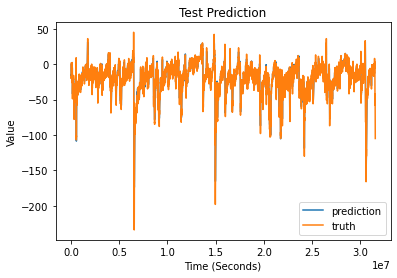

In [21]:
tester.plot(predictions, -1, 'DST1800')

Get encodings over the downloaded testing data using the default stride (out_steps)

In [22]:
encodings = tester.test(encoder_model)
encodings = np.array(encodings)
# note that these encoding values cannot be ploted using the tester

Plot the encodings with TSNE and PCA since the encoding vectors have more than 2 dimensions

In [23]:
x_data = encodings.reshape(
    (encodings.shape[0], np.prod(encodings.shape[1:]))
)

/home/jovyan/users_conda_envs/HAPINN/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


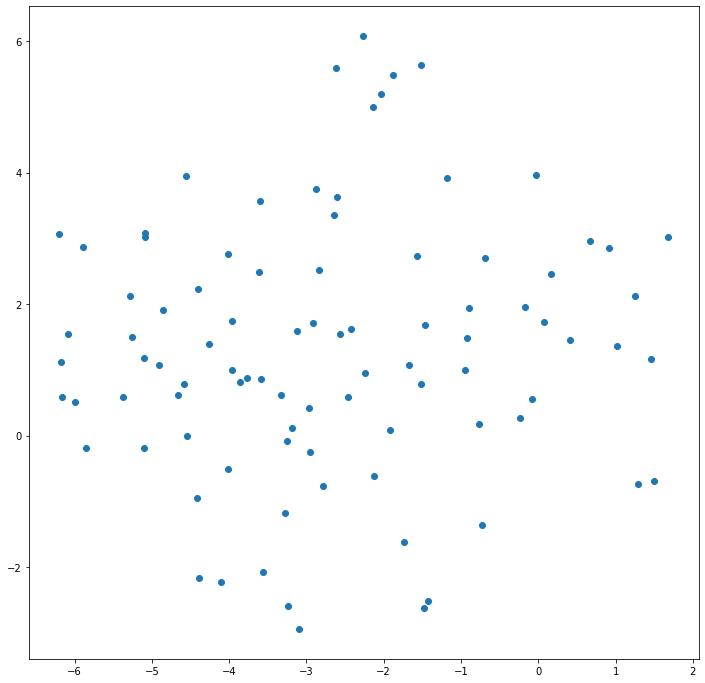

In [24]:
model = TSNE(n_components=2, init='pca', learning_rate='auto')
tsne_transformed = model.fit_transform(x_data)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1])
plt.show()

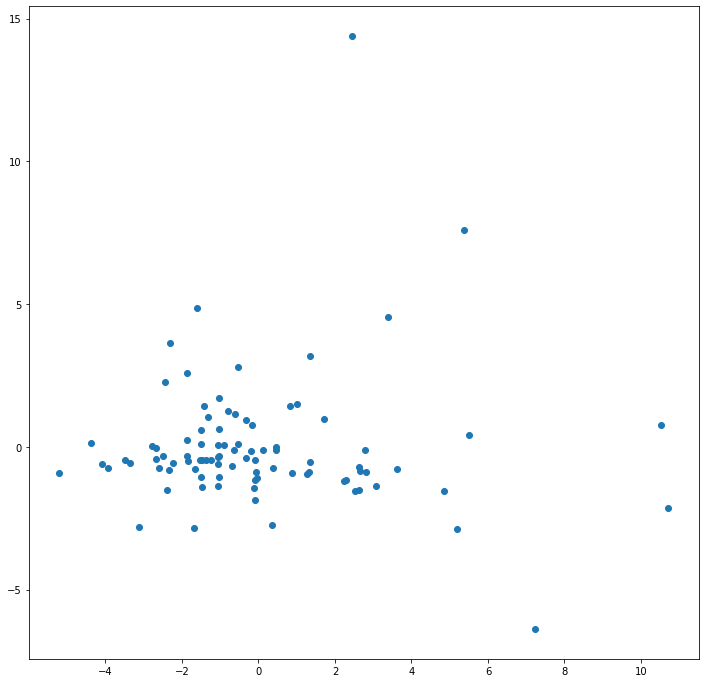

In [25]:
model = PCA(n_components=2)
pca_transformed = model.fit_transform(x_data)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(pca_transformed[:, 0], pca_transformed[:, 1])
plt.show()

Cluster the test data using KMeans and GaussianMixture

KMeans has it's own transform, so plot clusters on that transform so long as only 2 clusters

In [26]:
ndxs = np.arange(len(encodings))
pred_ndxs = np.floor(ndxs / tester.out_steps).tolist()
time_ndxs = ndxs * 60 * 60 * tester.out_steps
# assuming start date of test data is Jan. 1st, 2015
dates = [datetime.utcfromtimestamp(x) for x in (time_ndxs + datetime(year=2015, month=1, day=1).timestamp())]

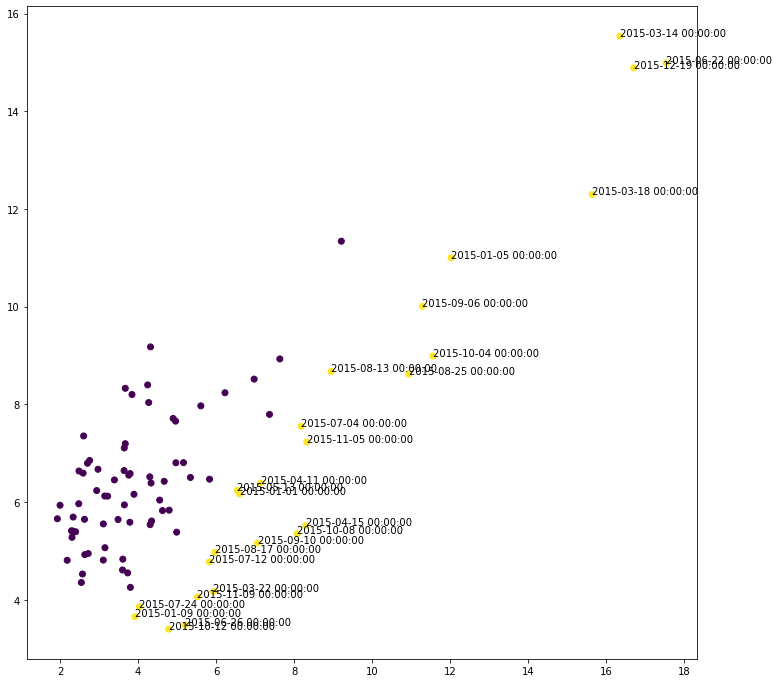

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0], dtype=int32)

In [27]:
model = KMeans(n_clusters=2)
model.fit(x_data)
transformed = model.fit_transform(x_data)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(transformed[:, 0], transformed[:, 1], c=model.labels_)
for ndx in range(len(transformed)):
    if model.labels_[ndx] == 1:
        ax.annotate(dates[ndx], (transformed[ndx, 0], transformed[ndx, 1]))
plt.show()
model.labels_

Compute GaussianMixture and plot on PCA transform

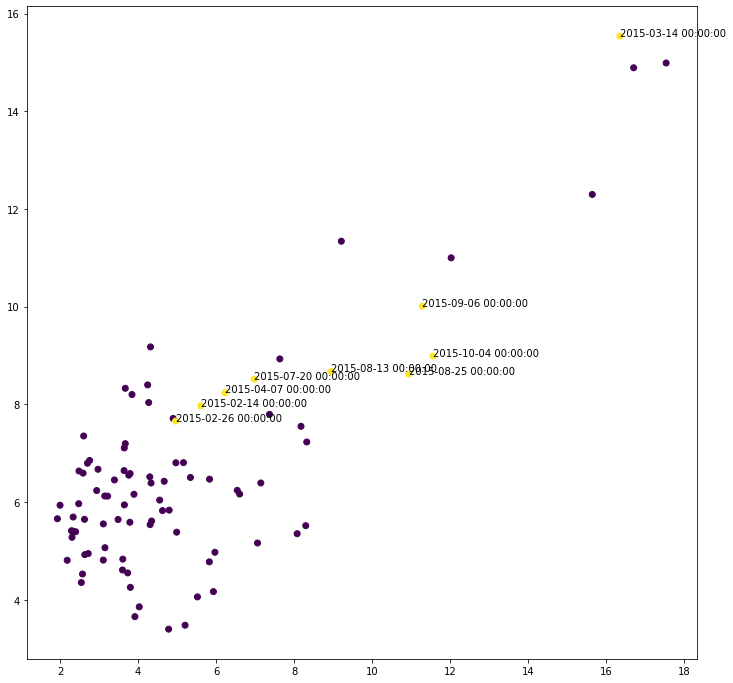

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [31]:
model = GaussianMixture(n_components=2)
model.fit(x_data)
labels = model.fit_predict(x_data)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(transformed[:, 0], transformed[:, 1], c=labels)
for ndx in range(len(transformed)):
    if labels[ndx] == 1:
        ax.annotate(dates[ndx], (transformed[ndx, 0], transformed[ndx, 1]))
plt.show()
labels

Focus on a few of the two clusters by plotting them individually

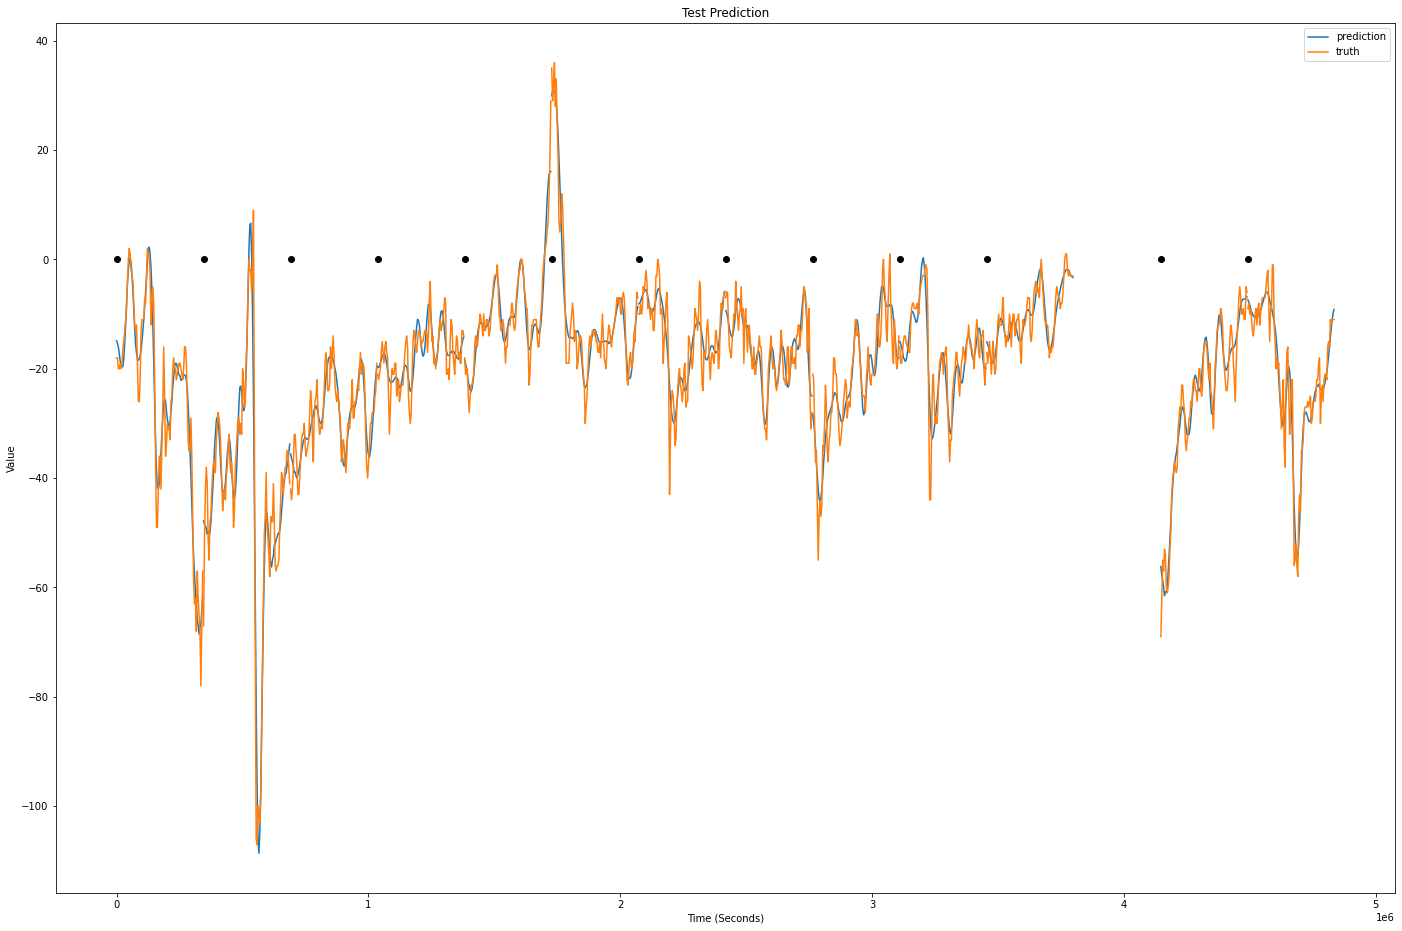

In [51]:
plt.figure(figsize=(24, 16))
for ndx, label in enumerate(labels[:len(labels)//6]):
    if label == 0:
        tester.plot(predictions, ndx, 'DST1800')
        plt.scatter(time_ndxs[ndx], 0, c='k')

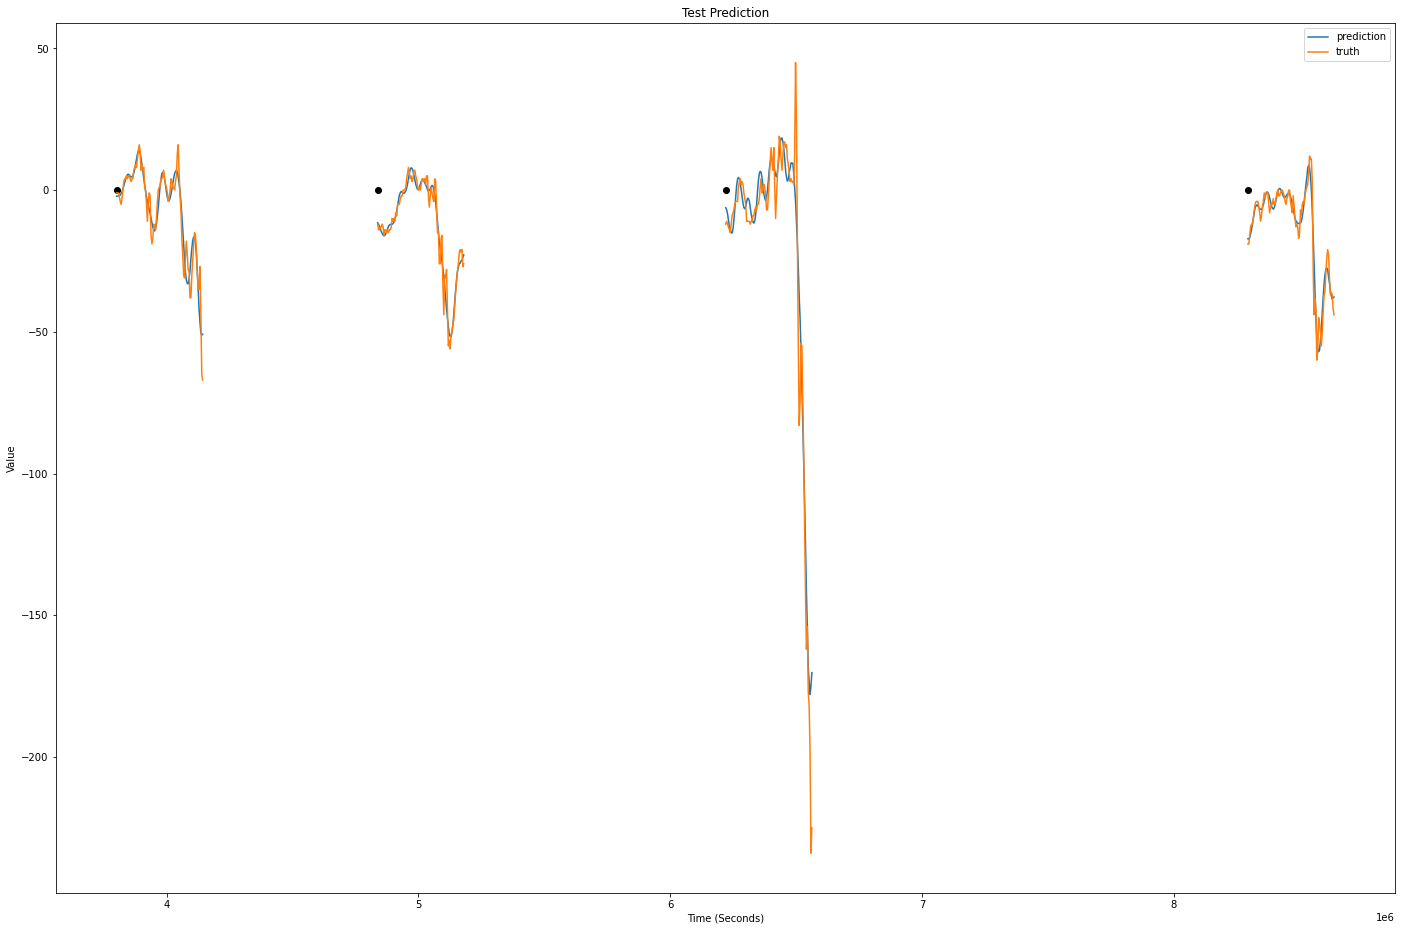

In [49]:
plt.figure(figsize=(24, 16))
for ndx, label in enumerate(labels[:len(labels)//2]):
    if label == 1:
        tester.plot(predictions, ndx, 'DST1800')
        plt.scatter(time_ndxs[ndx], 0, c='k')

### Conclusion

For the most part there seems to be a pattern in the second cluster that differentiates the two clusters. This pattern is the presences of extreme dips near the end of the series. However, the first cluster does have a couple instances with a similar pattern but these have spikes upward before the dip in their series reconstruction. The differences in the clusters does not seem to perfectly split on CMEs or Flares, with both clusters having such events.

©️ 2022 The Johns Hopkins University Applied Physics Laboratory LLC.